In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

sns.set_theme()

In [2]:
data = pd.read_csv('municipality_bus_utilization.csv')

In [3]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB


,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113


In [4]:
## No missing values?
data.isna().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [5]:
# Maximum usage in a hour for each municipality
data.timestamp = pd.to_datetime(data.timestamp)
data = data.groupby(['municipality_id', pd.Grouper(key='timestamp', freq='H')])['usage'].max()
data = data.reset_index()
data

,municipality_id,timestamp,usage
0,0,2017-06-04 07:00:00,204
1,0,2017-06-04 08:00:00,332
2,0,2017-06-04 09:00:00,485
3,0,2017-06-04 10:00:00,583
4,0,2017-06-04 11:00:00,614
...,...,...,...
6735,9,2017-08-19 12:00:00,849
6736,9,2017-08-19 13:00:00,941
6737,9,2017-08-19 14:00:00,983
6738,9,2017-08-19 15:00:00,976


Text(0.5, 1.0, 'Maximum usage in a hour for each municipality')

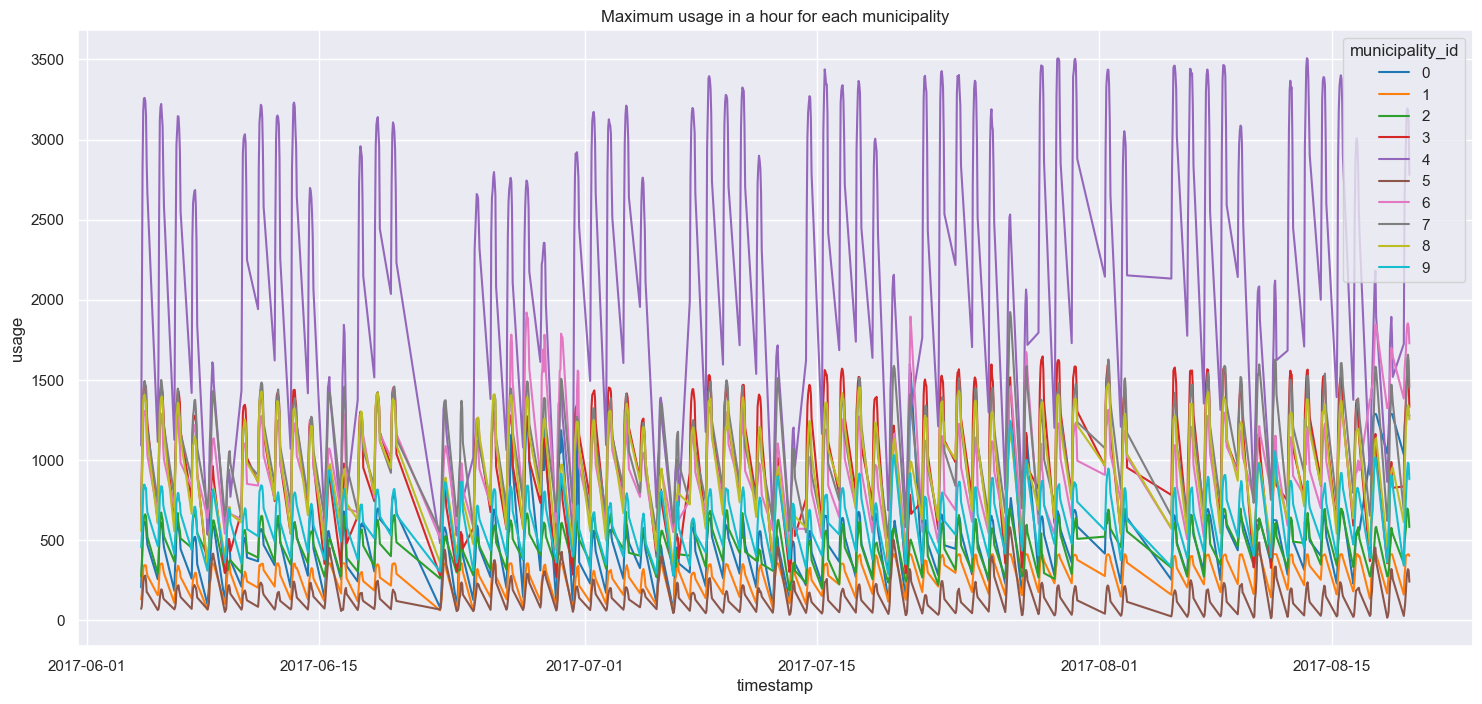

In [6]:
fig = sns.lineplot(data=data, x='timestamp', y='usage', hue='municipality_id', palette='tab10')
fig.figure.set_size_inches(18, 8)
fig.set_title('Maximum usage in a hour for each municipality')

Text(0.5, 1.0, 'Average usage of weeks for each municipality')

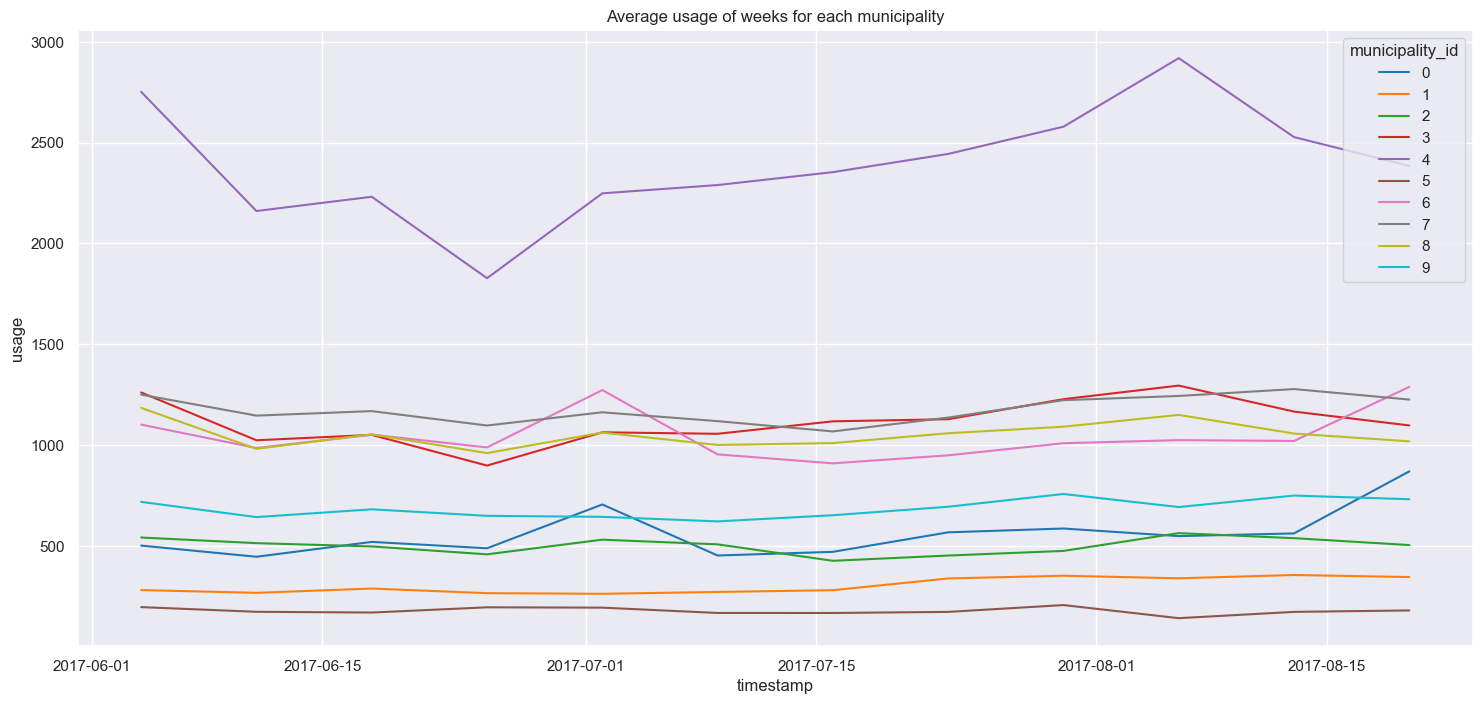

In [7]:
data_temp = data.groupby(['municipality_id', pd.Grouper(key='timestamp', freq='1w')])['usage'].mean()
data_temp = data_temp.reset_index()
fig = sns.lineplot(data=data_temp, x='timestamp', y='usage', hue='municipality_id', palette='tab10')
fig.figure.set_size_inches(18, 8)
fig.set_title('Average usage of weeks for each municipality')

In [8]:
train_data = data[data.timestamp < '2017-08-05']
test_data = data[data.timestamp >= '2017-08-05']

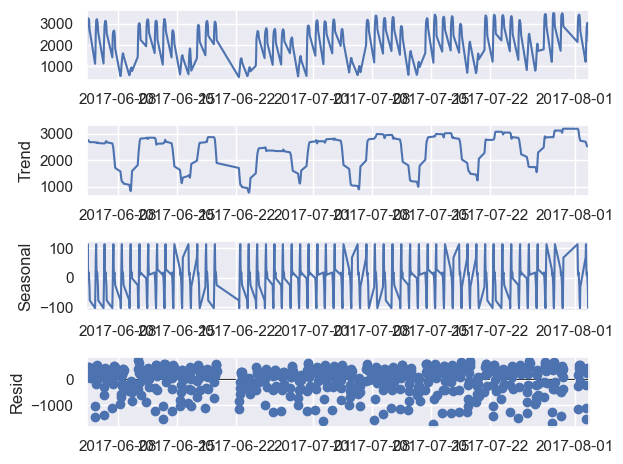

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_df = pd.Series(train_data[train_data.municipality_id == 4].usage.values, index=train_data[train_data.municipality_id == 4].timestamp)


result = seasonal_decompose(decomp_df, model='additive', period=10)
result.plot()
plt.show()

c:\Users\can_i\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


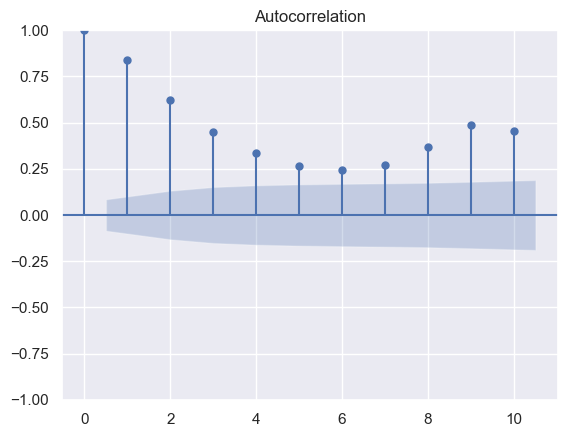

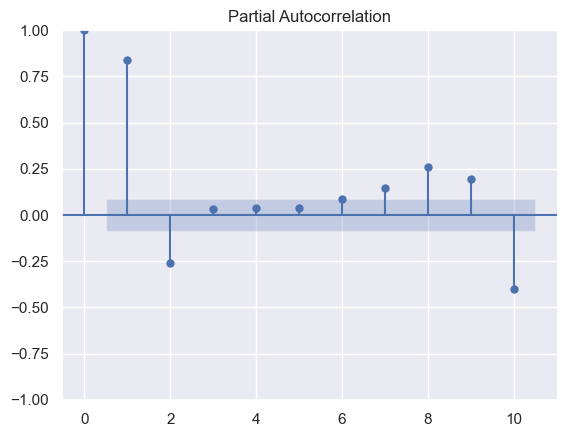

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_plot = plot_acf(train_data.usage[train_data.municipality_id == 4], lags=10)
pacf_plot = plot_pacf(train_data.usage[train_data.municipality_id == 4], lags=10)

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

train_usage = train_data.usage[train_data.municipality_id == 4]
test_usage = test_data.usage[test_data.municipality_id == 4]

In [101]:
arima = ARIMA(endog=train_usage, order=(2,1,6))
arima_fit = arima.fit()
# print(arima_fit.summary())

predictions = arima_fit.forecast(len(test_usage))
predictions = pd.Series(predictions.values, index=test_usage.index)

c:\Users\can_i\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\can_i\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\can_i\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\can_i\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\can_i\AppData\Local\Programs\Py

RMSE:  802.1400083944761
MAE:  652.4730031505766


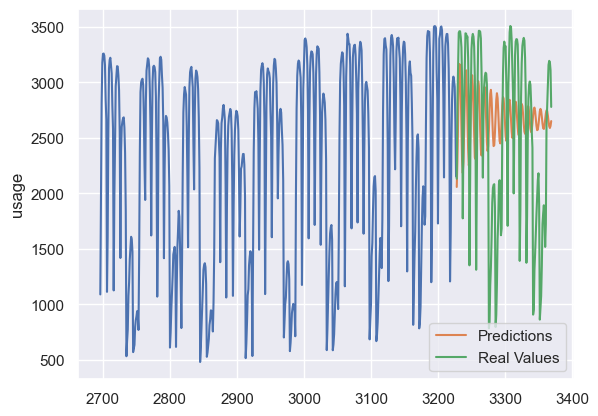

In [102]:
sns.lineplot(train_usage)
sns.lineplot(predictions, label='Predictions')
sns.lineplot(test_usage, label='Real Values')

rms = mean_squared_error(test_usage, predictions, squared=False)
mae = mean_absolute_error(test_usage, predictions)

print('RMSE: ', rms)
print('MAE: ', mae)

In [172]:
sarimax = SARIMAX(endog=train_usage, order=(2,1,6), seasonal_order=(2,1,1,10))

sarimax_fit = sarimax.fit()
# print(sarimax_fit.summary())

predictions = sarimax_fit.forecast(len(test_usage))
predictions = pd.Series(predictions.values, index=test_usage.index)

c:\Users\can_i\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\can_i\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\can_i\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\can_i\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE:  813.877231859701
MAE:  728.4434725959054


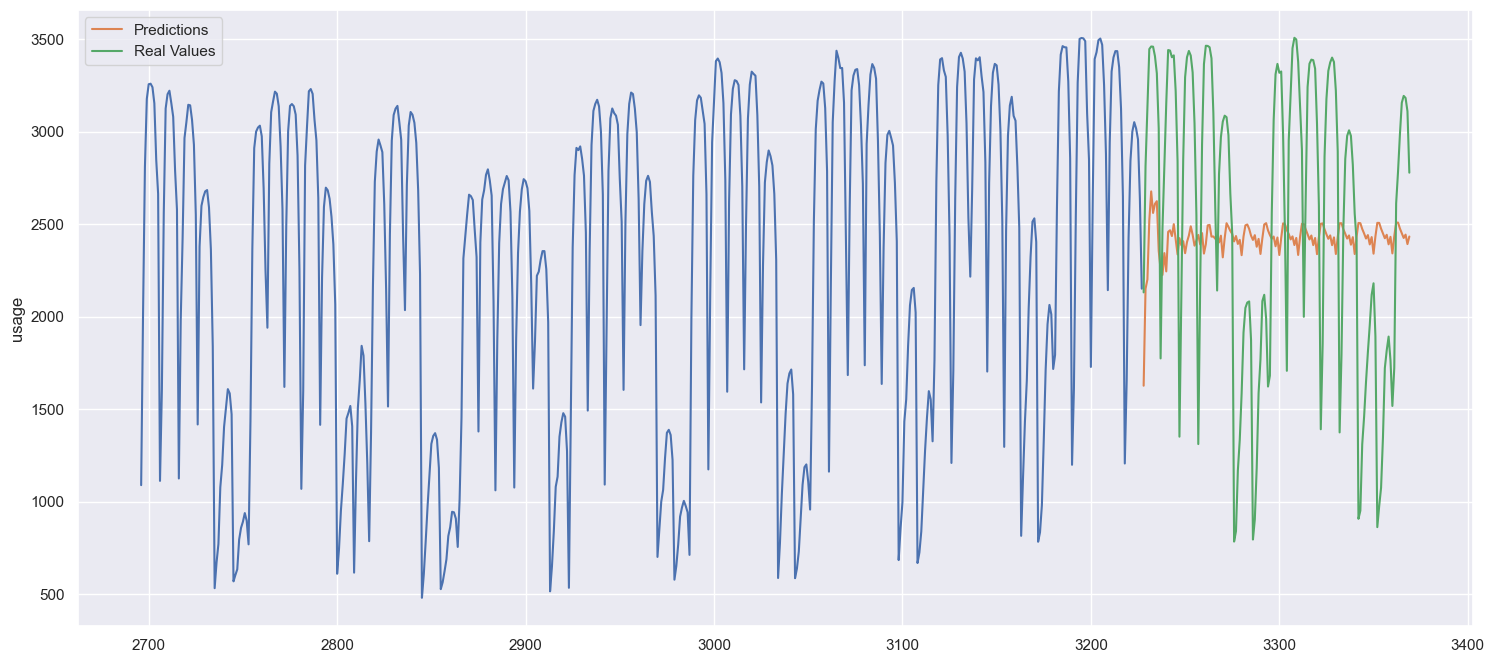

In [173]:
sns.lineplot(train_usage)
sns.lineplot(predictions, label='Predictions')
fig = sns.lineplot(test_usage, label='Real Values')
fig.figure.set_size_inches(18, 8)

rms = mean_squared_error(test_usage, predictions, squared=False)
mae = mean_absolute_error(test_usage, predictions)

print('RMSE: ', rms)
print('MAE: ', mae)